# Basic Iterative Method

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output

# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

from modules.bim import attack_BIM

from modules.bim import all_samples_attack_BIM
from modules.bim import confidence_range_attack_BIM
from modules.bim import visualize_attack_BIM

from modules.bim import single_attack_stats_BIM
from modules.bim import analyze_attack_BIM

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack

BIM requires the following function, which clips pixel values of an image $X^\prime$:

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = \frac{1}{255}$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

## 2. Attack

Number of iterations: 20
			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			whistle
Confidence: 		99.99%				71.91%



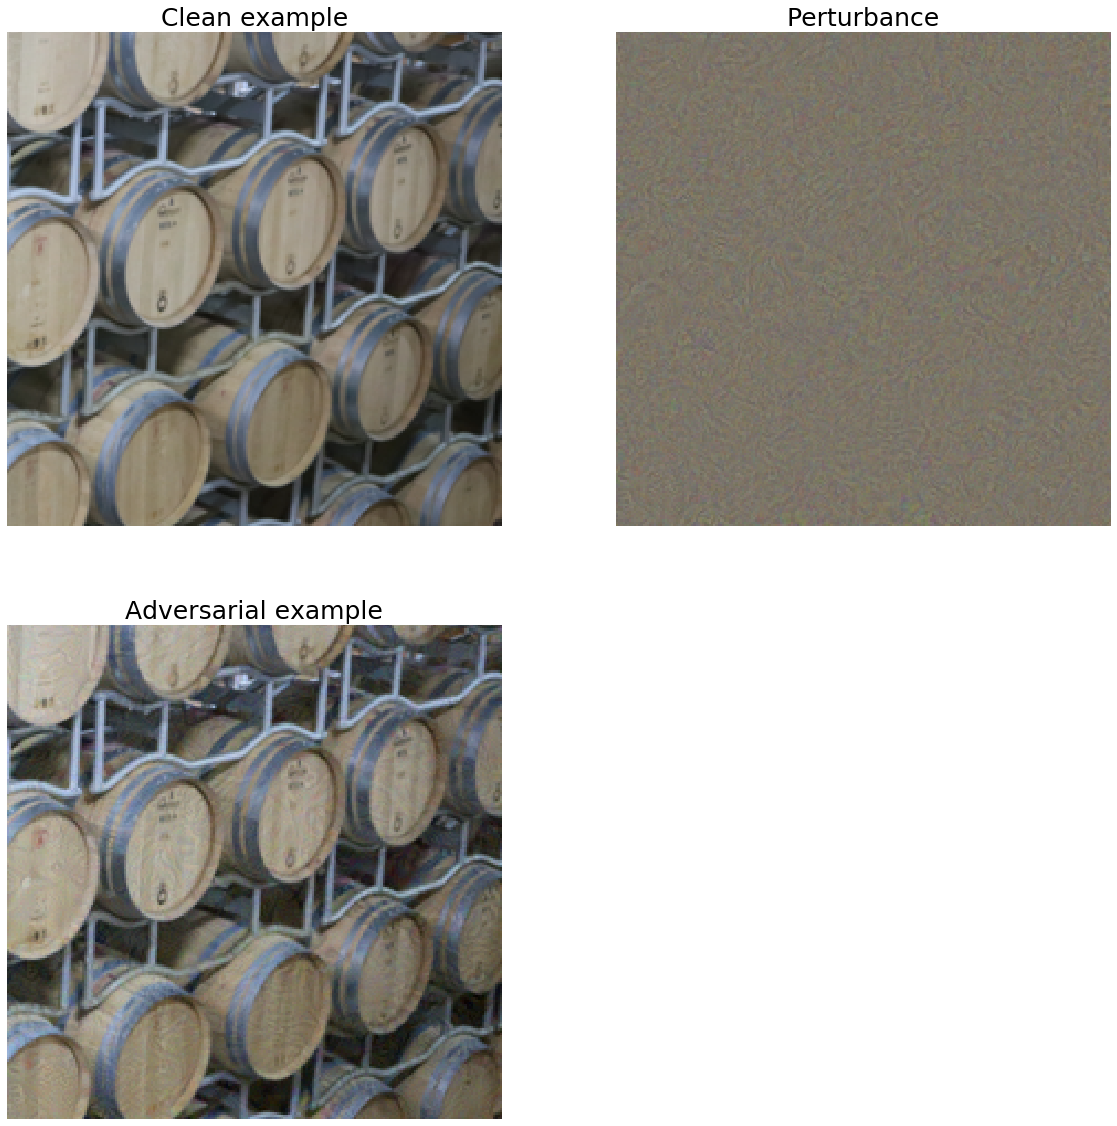

In [4]:
alpha = 1/255
epsilon = 16/255
sample = 766

visualize_attack_BIM(data_loader, mean, std, model, predict, epsilon, alpha, sample, summarize_attack,folder=None)

## 0. Introduction

## 1. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 1.1 Intervals of initial confidences

use function `confidence_range_attack_BIM`

In [5]:
# Phil -> Done
max_confidence = 0.60
min_confidence = 0.40


# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255


result = confidence_range_attack_BIM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

Running for epsilon 0.00
Sample: 6 of 155
Accuracy top 1 adversarial: 1.00
Accuracy top 5 adversarial: 1.00
Confidence adversarial: 0.52
Number of iterations: 0


KeyboardInterrupt: 

In [4]:
# Dave -> Done
max_confidence = 0.90
min_confidence = 0.85


# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255] 
alpha = 1/255

result = confidence_range_attack_BIM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

Running for epsilon 60.00
Sample: 69 of 69
Accuracy top 1 adversarial: 0.00
Accuracy top 5 adversarial: 0.00
Confidence adversarial: 0.72
Number of iterations: 64


In [ ]:
# Phil -> Done
max_confidence = 0.95
min_confidence = 0.90


# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_BIM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
# Phil -> In progress
max_confidence = 0.99
min_confidence = 0.95


# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_BIM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
# Dave -> Done

max_confidence = 1.00
min_confidence = 0.99


# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_BIM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

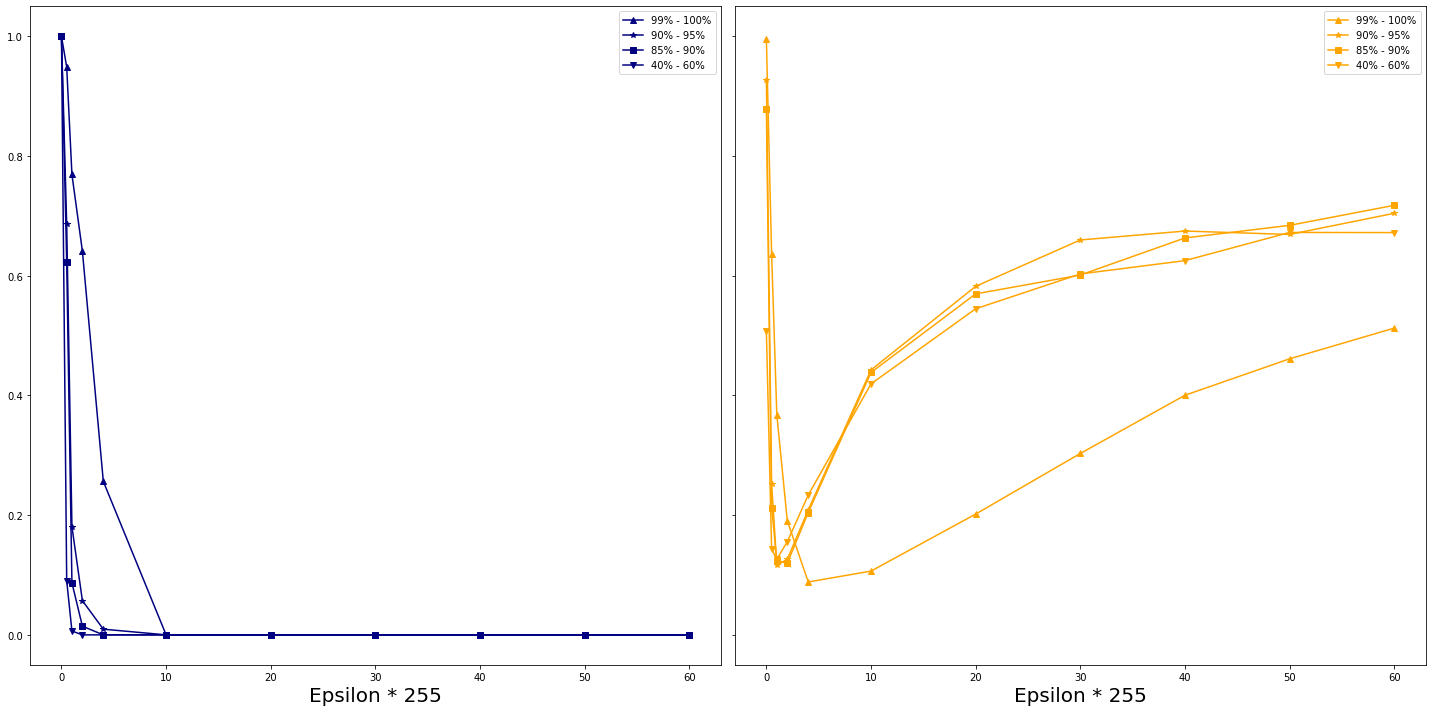

In [8]:
### PLOT 1

# Load data
result_99 = pd.read_csv("results/BIM/BIM-Conf99.csv")
result_95 = pd.read_csv("results/BIM/BIM-Conf95.csv")
result_90 = pd.read_csv("results/BIM/BIM-Conf90.csv")
result_85 = pd.read_csv("results/BIM/BIM-Conf85.csv") 
result_40 = pd.read_csv("results/BIM/BIM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/BIM/Accuracies_Confidences.pdf")
fig.savefig("plots/BIM/Accuracies_Confidences.png")

## 2. Indivdual Images

### 2.1 Confidence and correct/false class over epsilon for individual images
Can you find one which:
- Cannot be forced to change the class
- Changes class and then changes back?
- Has higher adversarial confidence than initial confidence

In [ ]:
# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [1/255, 2/255, 4/255, 6/255, 8/255, 10/255]


result = pd.DataFrame()

for epsilon in epsilons:   
    conf = []
    
    for idx in range(1000):
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print(idx+1)
        conf_adv, acc, label_adv = get_confidence_acc_class(epsilon, idx)
        
        if acc == 1:
            conf.append(conf_adv)

        else:
            conf.append(0)

    result["Epsilon " + str(int(epsilon*255))] = conf

#result.to_csv("results/BIM-accuracies-corr_only.csv")

In [ ]:
result = pd.read_csv("results/BIM-accuracies-corr_only.csv", index_col=0)
result

#### 2.1.1 Predicted class invariant

#### Increasing interations

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.5			1	0.9984958	honeycomb
1.0			1	0.9984958	honeycomb
2.0			1	0.9984958	honeycomb
4.0			1	0.9984958	honeycomb
8.0			1	0.9984958	honeycomb
12.0			1	0.9984958	honeycomb
16.0			1	0.9984958	honeycomb
20.0			1	0.9984958	honeycomb


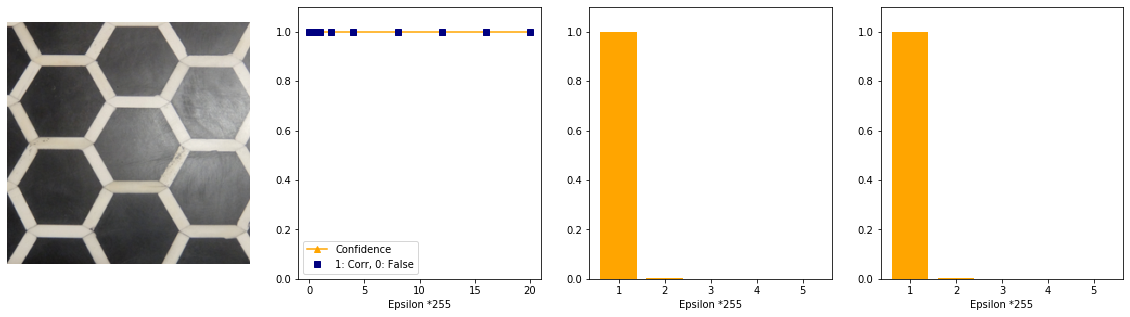

In [4]:
sample = 132
alpha = 1/255
num_iter = 1
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=None, save_plot=False, print_output=True)

Epsilon 	 Accuracy 	 Confidence 	 Label


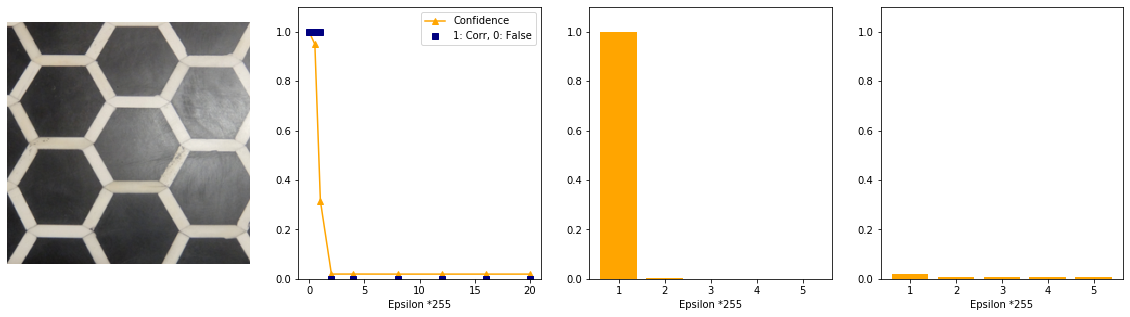

In [5]:
sample = 132
alpha = 1/255
num_iter = 5
epsilon_conf = 4/255

analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


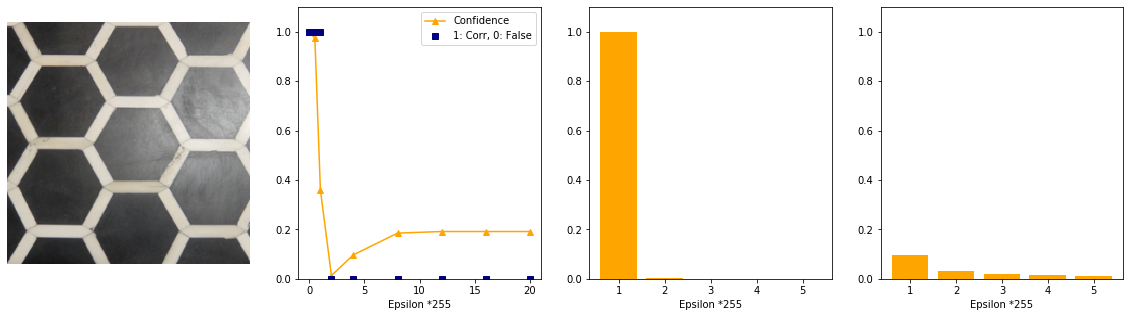

In [6]:
sample = 132
alpha = 1/255
num_iter = 10
epsilon_conf = 4/255

analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


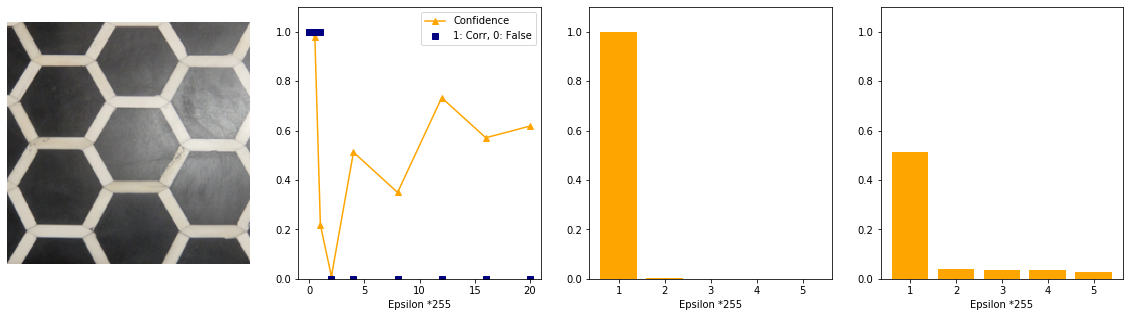

In [7]:
sample = 132
alpha = 1/255
num_iter = 20
epsilon_conf = 4/255

analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

#### Lowering alpha

Epsilon 	 Accuracy 	 Confidence 	 Label


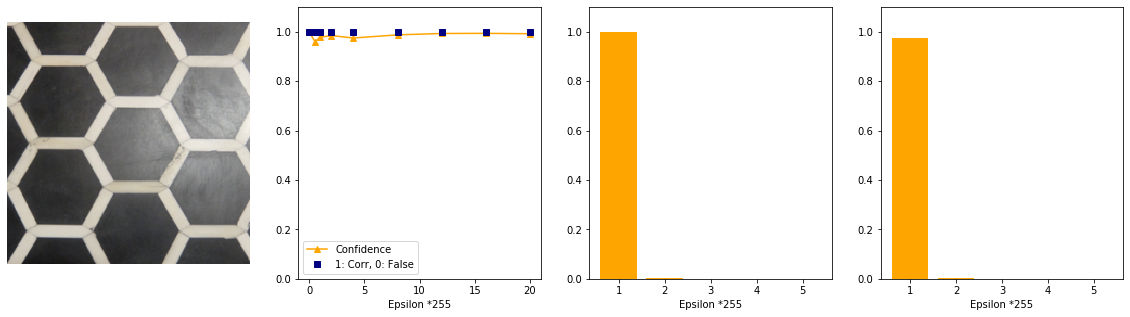

In [8]:
sample = 132
alpha = 127/255
num_iter = 2
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


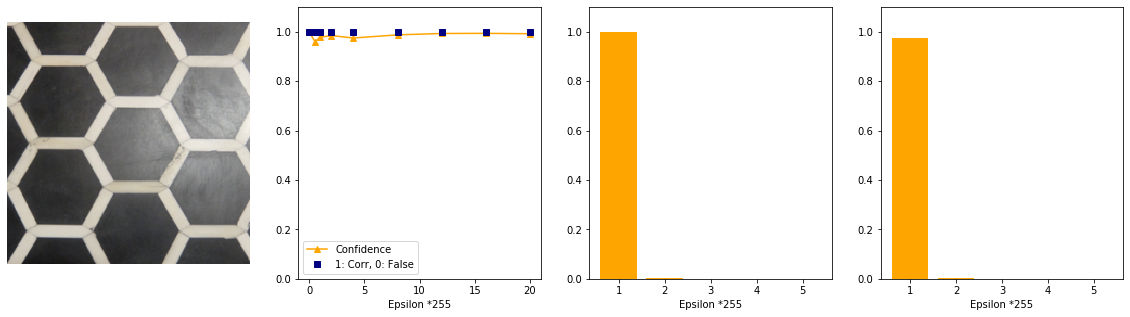

In [9]:
sample = 132
alpha = 68/255
num_iter = 2
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


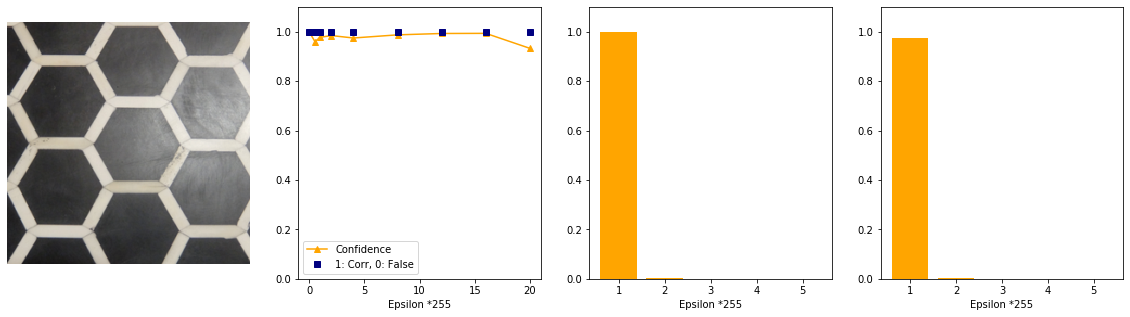

In [10]:
sample = 132
alpha = 34/255
num_iter = 2
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


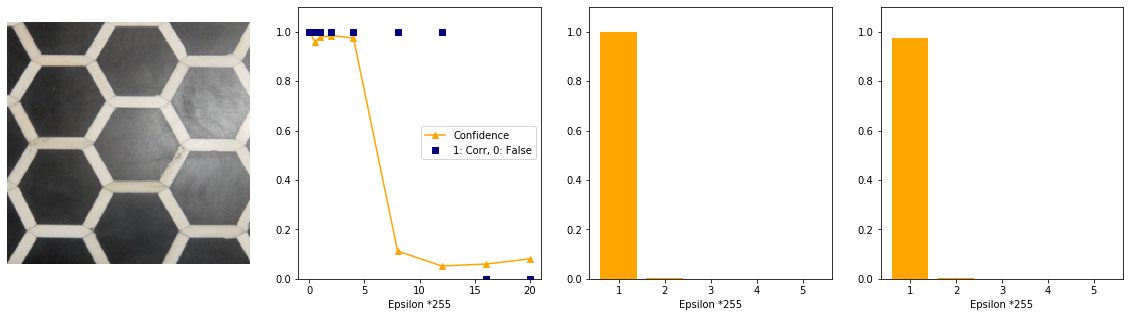

In [11]:
sample = 132
alpha = 10/255
num_iter = 2
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

#### Combining alpha and iterations

Epsilon 	 Accuracy 	 Confidence 	 Label


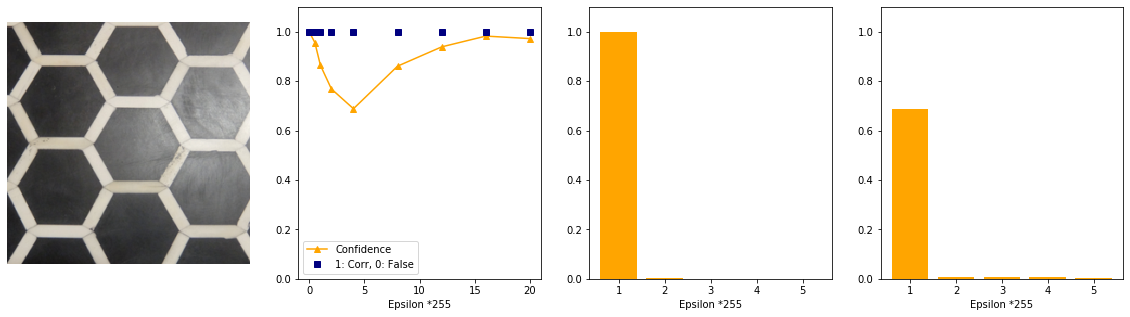

In [12]:
sample = 132
alpha = 127/255
num_iter = 15
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


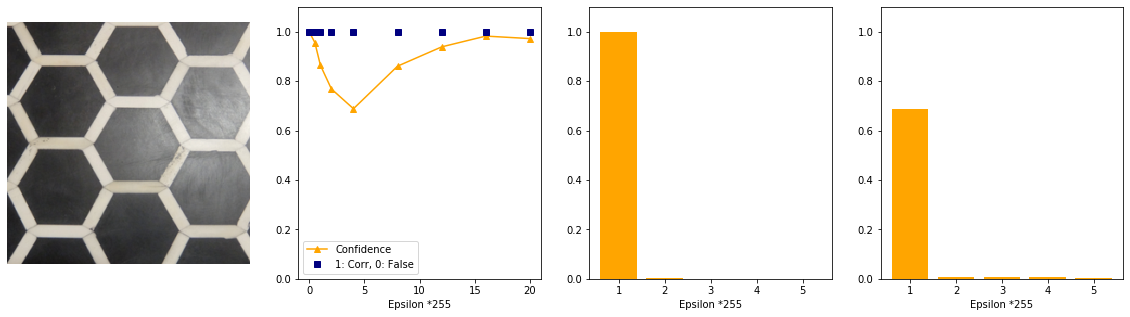

In [13]:
sample = 132
alpha = 68/255
num_iter = 15
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


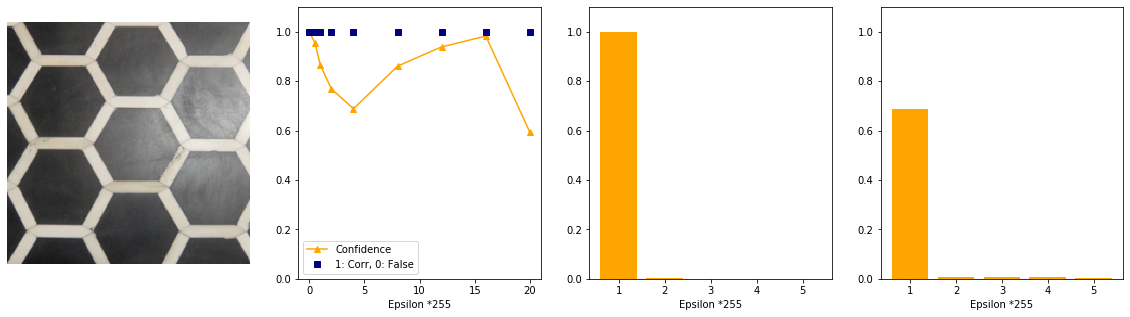

In [14]:
sample = 132
alpha = 34/255
num_iter = 15
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


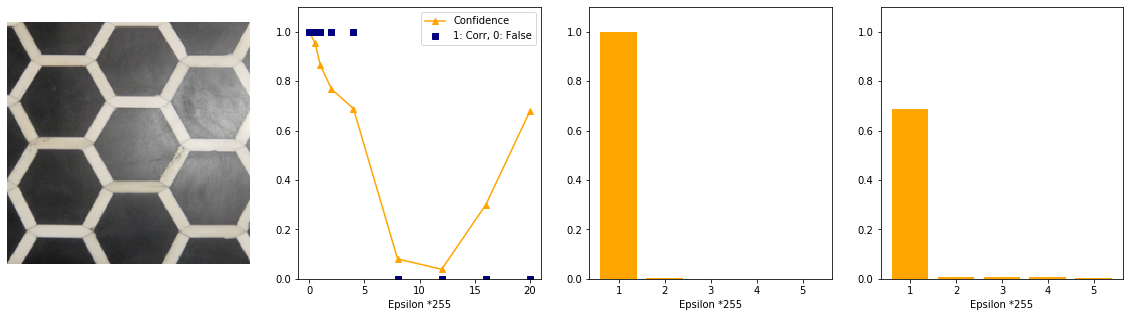

In [15]:
sample = 132
alpha = 10/255
num_iter = 15
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

In [23]:
## Make subplot 3x3




## Apron example

Epsilon 	 Accuracy 	 Confidence 	 Label


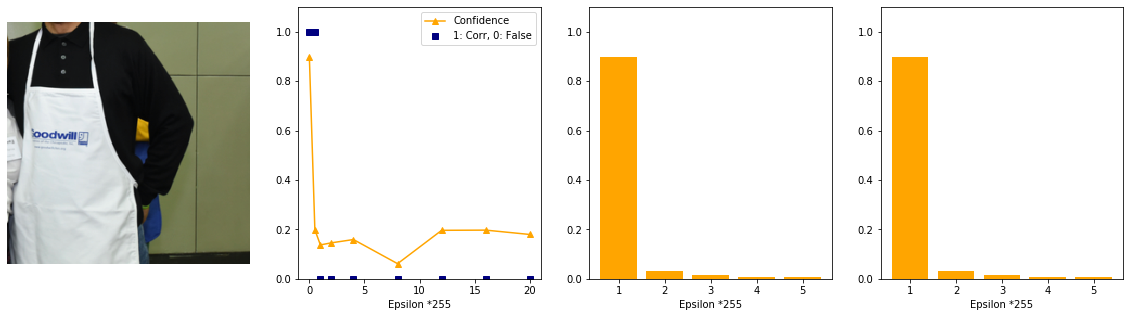

In [24]:
sample = 432
alpha = 10/255
num_iter = 15
epsilon_conf = 0/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


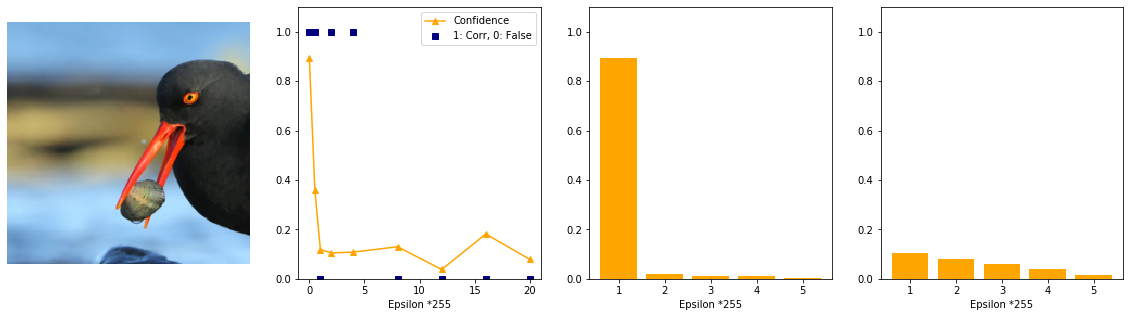

In [25]:
sample = 323
alpha = 10/255
num_iter = 15
epsilon_conf = 2/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

#### 2.1.2 Class bounces back

Epsilon 	 Accuracy 	 Confidence 	 Label


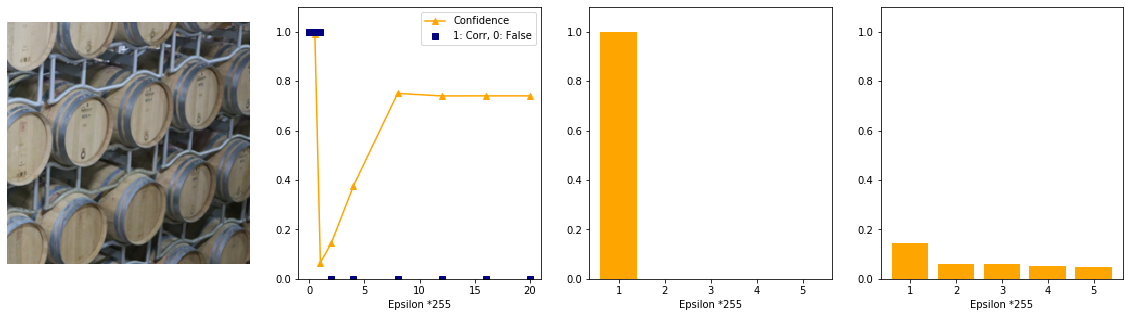

In [26]:
sample = 766
alpha = 1/255
num_iter = 15
epsilon_conf = 2/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


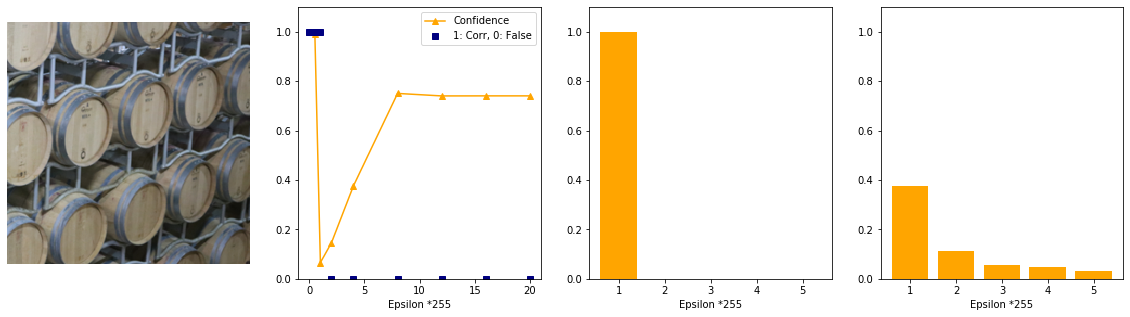

In [27]:
sample = 766
alpha = 1/255
num_iter = 15
epsilon_conf = 4/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


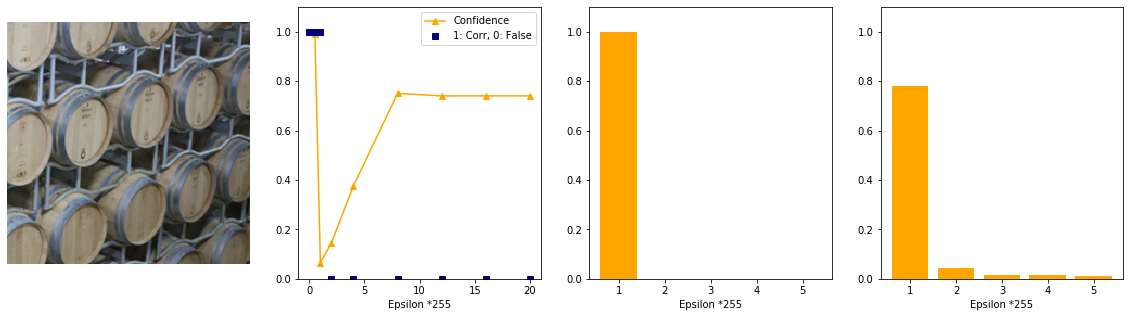

In [28]:
sample = 766
alpha = 1/255
num_iter = 15
epsilon_conf = 5/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


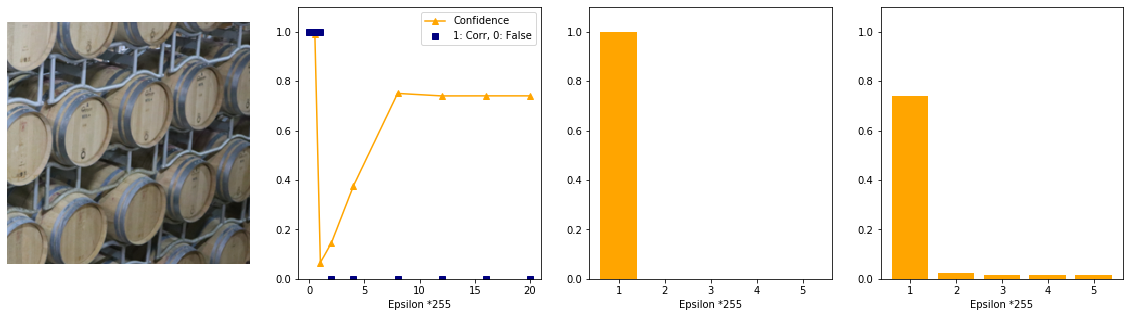

In [29]:
sample = 766
alpha = 1/255
num_iter = 15
epsilon_conf = 18/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

Epsilon 	 Accuracy 	 Confidence 	 Label


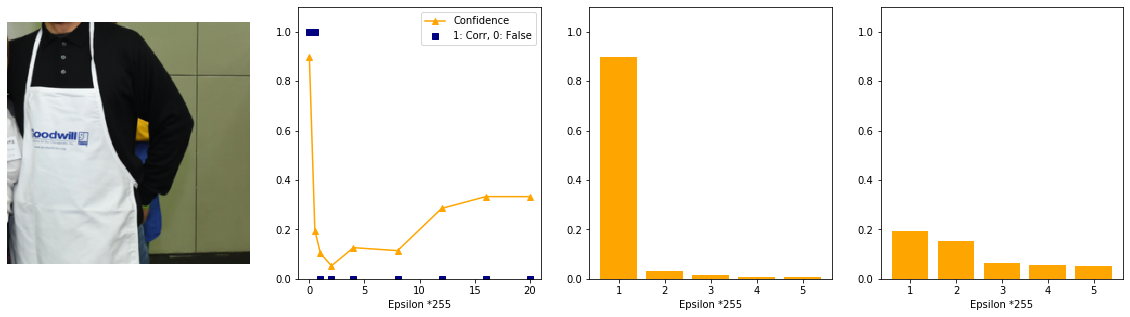

In [30]:
sample = 432
alpha = 1/255
num_iter = 15
epsilon_conf = 0.5/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

#### 2.1.3 Adversarial confidence greater than initial confidence

In [ ]:
#--------> Find more examples!!!!!

Epsilon 	 Accuracy 	 Confidence 	 Label


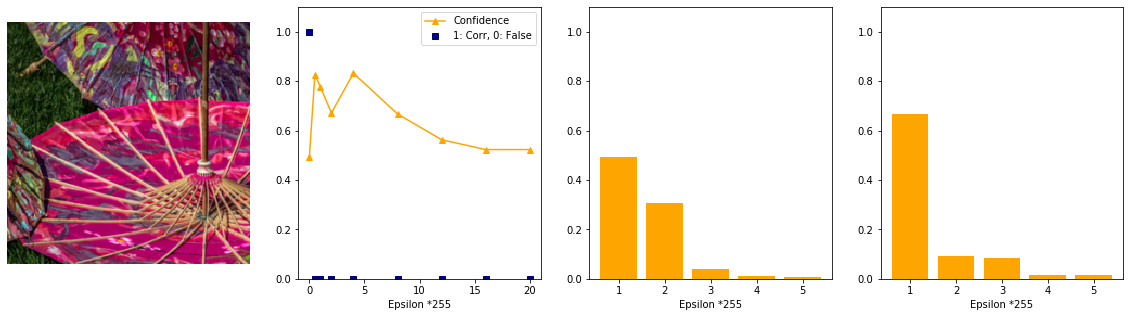

In [31]:
sample = 258
alpha = 1/255
num_iter = 15
epsilon_conf = 8/255
analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, show_tensor_image, idx_to_name, num_iterations=num_iter, save_plot=False, print_output=False)

# Confidence up to 94% for wrong class at epsilon=8

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

#### Comparison paper p.5
FGSM vs. BIM when including false initial predictions.

In [ ]:
## Part 1 -> Colab 1: Running
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255]

alpha = 1/255 # recommended in paper
filename_ext = "0-32"
temp_file = "1"
restart =["96_part-3", [0, 1/255]]

top1, top5, conf = all_samples_attack_BIMcompute_all_bim(model, data_loader, predict, mean, std, epsilons, alpha, filename_ext, temp_file)

In [ ]:
## Part 2 -> Colab 2: Running
epsilons = [48/255, 64/255]

alpha = 1/255 # recommended in paper
filename_ext = "48-64"

top1, top5, conf = all_samples_attack_BIM(model, data_loader, predict, mean, std, epsilons, alpha, filename_ext)

In [ ]:
## Part 3 -> Open
epsilons = [96/255]

alpha = 1/255 # recommended in paper
filename_ext = "96"

top1, top5, conf = all_samples_attack_BIM(model, data_loader, predict, mean, std, epsilons, alpha, filename_ext)

In [ ]:
## Part 4 -> Colab 3: Running
epsilons = [128/255]

alpha = 1/255 # recommended in paper
filename_ext = "128"

top1, top5, conf = all_samples_attack_BIM(model, data_loader, predict, mean, std, epsilons, alpha, filename_ext)

In [ ]:
plt.plot(conf, color='navy')

In [ ]:
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255, 48/255, 64/255, 96/255, 128/255]
top1, top5, conf = all_samples_attack_BIM(model, data_loader, predict, mean, std, epsilons)

In [ ]:
plt.plot(np.array(epsilons)*255, top1, "-o", color='navy', label='Top 1')
plt.plot(np.array(epsilons)*255, top5, "-o", color='navy', label='Top 5')
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
plt.plot(np.array(epsilons)*255, conf, "-*", color='orange', label='Confidence')
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Confidence")
plt.show()

## Comparison: FGSM BIM and ILLM

In [ ]:
fgsm = pd.read_csv("results/FGSM/FGSM-all_samples.csv", index_col=0)
bim = pd.read_csv("results/BIM/BIM-all_samples.csv", index_col=0)
bim

In [ ]:
# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,5))

## Left: Accuracies
axs[0].plot(fgsm["Epsilon"], fgsm["Top1"], "-o", color='navy', label='FGSM Top 1')
axs[0].plot(fgsm["Epsilon"], fgsm["Top5"], "-s", color='navy', label='FGSM Top 5')
axs[0].plot(bim["Epsilon"], bim["Top1"], "-o", color='grey', label='BIM Top 1')
axs[0].plot(bim["Epsilon"], bim["Top5"], "-s", color='grey', label='BIM Top 5')
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Right: Confidences
axs[1].plot(fgsm["Epsilon"], fgsm["Confidence"], "-o", color='orange', label='FGSM Confidence')
axs[1].plot(bim["Epsilon"], bim["Confidence"], "-s", color='orange', label='BIM Confidence')

axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
#fig.savefig("plots/Compare-attacks.pdf")
#fig.savefig("plots/Compare-attacks.png")

In [ ]:
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*